In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [467]:
ch2img = dict()
alphabet = 'abcdefghijklmnopqrstuvwxyz 1234567890!?.,;:*^@#$%&+-=~\'"/()'
path = 'A/'
sentence = 'hi everyone!!!'

for i in range(1, 60):
    ch2img[alphabet[i-1]] = path + '{}.jpg'.format(i)

def sen2img(sentences):
    if type(sentences) == str:
        patch = []
        for i in sentences:
            try:
                patch.append(np.array(Image.open(ch2img[i])))
            except:
                patch.append(np.array(Image.open(ch2img['?'])))
        out = np.concatenate(patch, axis=1)
        return out
    

In [24]:
source = sen2img(sentence)

True


In [4]:
from google.cloud import vision
from google.cloud.vision import types
from PIL import Image, ImageDraw
import io
import googletrans

In [5]:
class FeatureType:
    PAGE = 1
    BLOCK = 2
    PARA = 3
    WORD = 4
    SYMBOL = 5

In [8]:
translator = googletrans.Translator()

In [105]:
def draw_boxes(image, bounds, color):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        draw.polygon([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], None, color)
    return image

In [104]:
def get_document_bounds(image_file, feature):
    # [START vision_document_text_tutorial_detect_bounds]
    """Returns document bounds given an image."""
    client = vision.ImageAnnotatorClient()

    bounds = []

    with io.open(image_file, 'rb') as image_file:
        content = image_file.read()

    image = types.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    document = response.full_text_annotation

    # Collect specified feature bounds by enumerating all document features
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                '''
                for word in paragraph.words:
                    for symbol in word.symbols:
                        if (feature == FeatureType.SYMBOL):
                            bounds.append(symbol.bounding_box)

                    if (feature == FeatureType.WORD):
                        bounds.append(word.bounding_box)
                '''
                if (feature == FeatureType.PARA):
                    bounds.append(paragraph.bounding_box)

            #if (feature == FeatureType.BLOCK):
            #    bounds.append(block.bounding_box)

        #if (feature == FeatureType.PAGE):
        #    bounds.append(block.bounding_box)

    # The list `bounds` contains the coordinates of the bounding boxes.
    # [END vision_document_text_tutorial_detect_bounds]
    return bounds


def render_doc_text(filein, fileout):
    image = Image.open(filein)
    bounds = get_document_bounds(filein, FeatureType.PAGE)
    draw_boxes(image, bounds, 'blue')
    bounds = get_document_bounds(filein, FeatureType.PARA)
    #print(bounds)
    draw_boxes(image, bounds, 'red')
    bounds = get_document_bounds(filein, FeatureType.WORD)
    draw_boxes(image, bounds, 'yellow')

    if fileout is not 0:
        image.save(fileout)
    else:
        image.show()

In [78]:
bound_list = get_document_bounds('spanish.jpg', 3)

In [114]:
render_doc_text('korean.jpg', 0)

In [371]:
def get_paragraph(image_file, fileout):
    client = vision.ImageAnnotatorClient()

    #with io.open(image_file, 'rb') as image_file:
    #    content = image_file.read()
    content = io.open(image_file, 'rb').read()
    image = types.Image(content=content)
    response = client.text_detection(image=image)
    annotation = response.full_text_annotation
    #texts = response.text_annotations
        
    breaks = vision.enums.TextAnnotation.DetectedBreak.BreakType
    paragraphs = []
    lines = []

    for page in annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                para = ""
                line = ""
                for word in paragraph.words:
                    for symbol in word.symbols:
                        line += symbol.text
                        if symbol.property.detected_break.type == breaks.SPACE:
                            line += ' '
                        if symbol.property.detected_break.type == breaks.EOL_SURE_SPACE:
                            line += ' '
                            lines.append(line)
                            para += line
                            line = ''
                        if symbol.property.detected_break.type == breaks.LINE_BREAK:
                            lines.append(line)
                            para += line
                            line = ''
                paragraphs.append(para)
    
    bounds = []
    for page in annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                #if (feature == 3):
                bounds.append(paragraph.bounding_box)
                
    #Draw box for paragraphs
    bound_image = Image.open(image_file)
    draw_boxes(bound_image, bounds, 'red')

    if fileout is not 0:
        bound_image.save(fileout)
    else:
        bound_image.show()
    
    bounds_list = []
    for bound in bounds:
        bounds_list.append([(bound.vertices[0].x, bound.vertices[0].y),
        (bound.vertices[1].x, bound.vertices[1].y),
        (bound.vertices[2].x, bound.vertices[2].y),
        (bound.vertices[3].x, bound.vertices[3].y)])
    
    

    print(paragraphs)
    #print(lines)
    return paragraphs, bounds, bounds_list

In [280]:
paragraph, bounds, bounds_list = get_paragraph('korean.jpg', 0)

['산과 바다가 하나가 되는 섬 ', '대이작도에 오신 걸 환영합니다 ', '인 ', 'enjcja ', '인천신문 ', 'uletenph ', '용진군 ']
['산과 바다가 하나가 되는 섬 ', '대이작도에 오신 걸 ', '환영합니다 ', '인 ', 'enjcja ', '인천신문 ', 'uletenph ', '용진군 ']


In [281]:
bounds_list

[[(166, 60), (272, 55), (272, 65), (166, 70)],
 [(186, 71), (456, 61), (458, 113), (188, 123)],
 [(416, 222), (429, 221), (429, 229), (416, 230)],
 [(319, 380), (338, 380), (338, 387), (319, 387)],
 [(308, 386), (363, 386), (363, 403), (308, 403)],
 [(302, 406), (360, 407), (360, 415), (302, 414)],
 [(232, 340), (227, 429), (199, 427), (204, 339)]]

In [90]:
trans_list = []
for word in paragraph:
    trans_list.append(translator.translate(word, dest='en').text)
print(trans_list)

['An island where the mountains and the sea are one', 'The', 'welcome.', 'ME', '10 people', 'Oongeun-gun', 'Ongjin-gun', 'Incheon Newspaper', 'NEW', 'TILITI']


In [9]:
import math

In [57]:
#[(440,31),(621,37),(620,59),(439,53)]
vertex = np.float32([(440,31), (621,37), (439, 53)])
vertex2 = np.float32([(0,0), (800, 0), (0, 150)])

In [396]:
def get_rotation_angle(vertex):
    angle = math.degrees(math.atan2(-1*(vertex[1][1] - vertex[0][1]), vertex[1][0] - vertex[0][0]))
    return angle

In [48]:
import cv2

In [50]:
open_cv_image = np.array(source) 
# Convert RGB to BGR 
open_cv_image = open_cv_image[:, :, ::-1].copy() 

In [183]:
def box_size(vertex):
    vec1 = np.subtract(vertex[1], vertex[0])
    vec2 = np.subtract(vertex[3], vertex[0])
    vec1_norm = np.linalg.norm(vec1)
    vec2_norm = np.linalg.norm(vec2)
    size = int(vec1_norm)+1, int(vec2_norm)+1
    return size

In [499]:
def paste_box(source, dest, angle, size, vertice, color):
    src_im = source
    angle = angle
    size = size
    blank = Image.new('RGBA', size=size, color=color).rotate(angle, expand=2)

    dst_im = dest
    dst_im.paste(blank, vertice, blank)
    im = src_im.convert('RGBA')
    #rot = im.resize(size).rotate(angle, expand=2)
    im.thumbnail(size, Image.ANTIALIAS)
    rot = im.rotate(angle)
    #print(rot)
    dst_im.paste(rot, vertice, rot)
    return dst_im

In [519]:
def main(filein):
    dest = Image.open(filein)
    paragraph, bounds, bounds_list = get_paragraph(filein, 'bounded.jpg')
    #print(bounds_list)
    color_list = []
    for bound in bounds_list:
        #color_list.append(get_background(dest, bound))
        color_list.append(get_color(dest, bound))
    for i, word in enumerate(paragraph):
        translated = translator.translate(word, dest='en').text.lower().replace('\u200b', '')
        rotation = get_rotation_angle(bounds_list[i])
        size = box_size(bounds_list[i])
        color = color_list[i]
        '''
        try:
            src_img = Image.fromarray(sen2img(translated))
        except:
            src_img = Image.fromarray(sen2img(' '))
        '''
        src_img = Image.fromarray(sen2img(translated))
        dest = paste_box(change_colors(src_img, color[0], color[1]), dest, rotation, size, bounds_list[i][0],color[0])
    dest.save('test.jpg')

In [520]:
main('menu.jpg')

['PARTY MENU ', 'Mixed Tapas ', 'Vegetarian Tapas ', 'Pan/Acitunas ', 'Pan/Acitunas ', 'Fresh warm bread & marinated olives ', 'Fresh warm bread & marinated olives ', 'Ensalada Espanola (v) Mixed salad ', 'Ensalada Espanola ', 'Mixed Salad ', 'Espinacs con Almendras Spinach with almonds ', 'Tortilla Espanola (v) Spanish potato & egg omelette ', 'Garbanzos Andaluza ', 'Chorizo al Vino ', 'Chickpeas with spinach & cumin ', 'Spanish sausage in rioja wine ', 'Tortilla Espanola Spanish potato omelette ', 'Albondigas Meatballs in our special sauce ', 'Patatas Bravas ', 'Calamares Fritos ', 'Fried potatoes in spicy tomato sauce ', 'Fried squid in batter ', 'Chanquetes Fritos . Fried whitebait ', 'Championes a la ajillo (v) Garlic mushrooms with peppers ', 'Championes a la ajillo (v) Garlic mushrooms with peppers ', 'Calabacin Frita Fried courgettes drizzeled with honey ', 'Paella de Valancia ', 'Paella de Verduras ', 'Safron rice with chicken, seafood and vegatables ', 'Safron rice with fresh

In [ ]:
def get_background(image):
    max_color = max(image.getcolors(image.size[0] * image.size[1]))[1]
    return (max_color[2], max_color[1], max_color[0])

In [485]:
import copy
def get_color(image, bound):
    ret = []

    b = copy.deepcopy(bound)
    
    i = 1
    bound[0] = (bound[0][0]-i,bound[0][1]-i)
    bound[1] = (bound[1][0]+i,bound[1][1]-i)
    bound[2] = (bound[2][0]+i,bound[2][1]+i)
    bound[3] = (bound[3][0]-i,bound[3][1]+i)

    def get_idp(p1, p2, n = 8):
        
        ret = []
      
        for i in range(1,n):
            idp = p1[0]*(1/n)*i+p2[0]*(1-(1/n)*i), p1[1]*(1/n)*i+p2[1]*(1-(1/n)*i)
            ret.append(idp)
        return ret
  
    pixels = []
    
    #idps = get_idp(bound[0],bound[1])+get_idp(bound[1],bound[2])+get_idp(bound[2],bound[3])+get_idp(bound[3],bound[0])
    for vertice in bound:
        pixels.append(list(image.getpixel(vertice)))
       
    #for idp in idps:
    #    pixels.append(list(image.getpixel(idp)))

    pixels = np.array(pixels)
    kmeans = KMeans(n_clusters=1).fit(pixels).cluster_centers_
    kmeans = kmeans.tolist()[0]
    back_color = (int(kmeans[2]), int(kmeans[1]), int(kmeans[0]))
    #back_color_reversed = (kmeans[0], kmeans[1], kmeans[2])
    
    ############ font color ###############
    
    for_font_color = get_idp(b[0],b[2],64)
    
    pixels = []
    
    for idp in for_font_color : 
        pixels.append(list(image.getpixel(idp)))
    
    pixels = np.array(pixels)
    
    kmeans = KMeans(n_clusters=2).fit(pixels).cluster_centers_
    c1 = (kmeans[0][2],kmeans[0][1],kmeans[0][0])
    c2 = (kmeans[1][2],kmeans[1][1],kmeans[1][0])
    
    #print(kmeans[1][0])
    
    c = [c1,c2]
    
    index_ = np.argmax([np.linalg.norm(np.subtract(c1,back_color)),np.linalg.norm(np.subtract(c2,back_color))])
    font_out = c[index_]
    
    return [back_color, (int(font_out[0]), int(font_out[1]), int(font_out[2]))]

In [407]:
get_background2(image, bounds_list[0])

(174.625, 116.125, 45.125)

In [415]:
def change_background(image, color):
    image = np.array(image) 
    image = image[:, :, ::-1].copy() 
    lower_white = np.array([200, 200, 200], dtype=np.uint8)
    upper_white = np.array([255, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(image, lower_white, upper_white)
    image[mask == 255] = color
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    
    return image

In [518]:
def change_colors(image, bg_color, font_color):
    image = np.array(image) 
    image = image[:, :, ::-1].copy() 
    bg_lower_white = np.array([200, 200, 200], dtype=np.uint8)
    bg_upper_white = np.array([255, 255, 255], dtype=np.uint8)
    bg_mask = cv2.inRange(image, bg_lower_white, bg_upper_white)
    ft_lower_black = np.array([0,0,0], dtype=np.uint8)
    
    ft_upper_black = np.array([80,80,80], dtype=np.uint8)
    ft_mask = cv2.inRange(image, ft_lower_black, ft_upper_black)
    print(bg_color)
    print(font_color)
    
    image[bg_mask == 255] = bg_color
    image[ft_mask == 0] = font_color
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    
    return image

In [254]:
image = Image.open('korean.jpg')

In [237]:
from sklearn.cluster import KMeans

In [465]:
def get_background(image, bound):
    pixels = []
    for vertice in bound:
        pixels.append(list(image.getpixel(vertice)))
    pixels = np.array(pixels)
    kmeans = KMeans(n_clusters=1).fit(pixels).cluster_centers_
    kmeans = kmeans.tolist()[0]
    center_color = (int(kmeans[2]), int(kmeans[1]), int(kmeans[0]))
    return center_color

In [273]:
get_background(image, bounds_list[0])

(51.0, 126.0, 183.25)

In [308]:
math.degrees(math.atan2(100, 2))

88.8542371618249

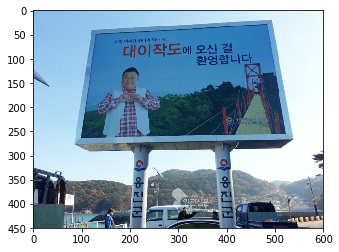

In [442]:
image = Image.open('korean.jpg')
plt.imshow(image)

In [445]:
#image = Image.open(source_path)
image.thumbnail((300,150), Image.ANTIALIAS)

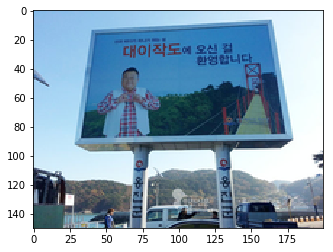

In [446]:
plt.imshow(image)